In [1]:
import os
import time
from datetime import datetime
from pathlib import Path

import akshare as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import snoop
from pylab import legend
from snoop import pp

from ystocks.functools import pickled_lru_cache, disk_cache

%matplotlib inline


In [2]:
fund_code = '510300'
init_cash = init_shares = cash = 100000
(
    f_buy_point,
    ss_buy_point,
    s_buy_point,
    buy_point,
    sell_point,
    s_sell_point,
    ss_sell_point,
    f_sell_point,
) = (0.005, 0.05, 0.15, 0.25, 0.7, 0.8, 0.9, 0.995)
fund_cache_file = f'../data/open_fund/{fund_code}.csv'


In [3]:
def recent_10_years(df):
    r_10_df = df.tail(10 * 12)
    # result_df = r_11_df.iloc[1:] #去除第一行异常数据
    return r_10_df.reset_index()

@disk_cache(cache_dir='../test-cached/')
def get_fund_as_df(fund_code) -> pd.DataFrame:
    return ak.fund_open_fund_info_em(
        fund=fund_code, indicator="单位净值走势")


def pre_process(df):
    df.drop(columns=['日增长率'], inplace=True)
    df['净值日期'] = pd.to_datetime(df['净值日期'], format='%Y-%m-%d')
    df.set_index(['净值日期'], drop=True, inplace=True)
    return df.resample("MS").first()


def ten_years_pct_change(df):
    recent_one_year_s = df['单位净值'].pct_change(periods=12)

    result_df = df.copy()
    result_df['近一年增长'] = recent_one_year_s

    # 处理前12行没有数据的问题
    result_df.loc[0, '近一年增长'] = 0
    for i in range(12):
        result_df.loc[i + 1,
                      '近一年增长'] = (df.loc[i + 1, '单位净值'] / df.loc[0, '单位净值']) - 1
    return result_df


def recacl_account(df):
    total_value = df['份额变化'] * df['单位净值']


def op_to_position(row, total_value, exp_position=0.7):
    global cash

    curr_position = 1 - cash / total_value

    exp_cash = total_value * (1 - exp_position)
    cash_to_op = cash - exp_cash
    if abs(cash_to_op / total_value) <= 0.01:  # 操作资金不足总资金量的0.5%
        # print(f"不足总资金的1%，无操作\n")
        return row

    op_row = row.copy()
    op_row['交易变化'] = cash_to_op
    op_row['份额变化'] = op_row['交易变化'] / op_row['单位净值']
    cash = exp_cash
    op_row['现金余额'] = cash
    # print(
    #     f"当前仓位: {curr_position}, 期望仓位: {exp_position}\n交易金额: {op_row['交易变化']}, 份额变化: {op_row['份额变化']}, 现金余额: {cash}, 总资产: {total_value}\n"
    # )
    return op_row


In [16]:
fund_df = get_fund_as_df(fund_code)
fund_df

2022-08-12 16:52:48.016 | DEBUG    | ystocks.functools:_wrapper:78 - [cd63be5832d82da63965ae61487239a4] hitted in cache


,净值日期,单位净值,日增长率
0,2012-05-04,1.0070,0.0000
1,2012-05-11,2.6370,-2.8606
2,2012-05-18,2.5740,-2.3891
3,2012-05-21,2.5880,0.5439
4,2012-05-25,2.5740,-0.5410
...,...,...,...
2493,2022-08-05,4.2178,1.4300
2494,2022-08-08,4.2091,-0.2100
2495,2022-08-09,4.2171,0.1900
2496,2022-08-10,4.1700,-1.1200


In [5]:

by_month_df = pre_process(fund_df)

recent_10_years_df = recent_10_years(by_month_df)
recent_10_years_df = ten_years_pct_change(recent_10_years_df)
recent_10_years_df


,净值日期,单位净值,近一年增长
0,2012-09-01,2.2650,0.000000
1,2012-10-01,2.3060,0.018102
2,2012-11-01,2.3340,0.030464
3,2012-12-01,2.1420,-0.054305
4,2013-01-01,2.5270,0.115673
...,...,...,...
115,2022-04-01,4.2728,-0.164114
116,2022-05-01,4.0087,-0.209002
117,2022-06-01,4.0891,-0.235982
118,2022-07-01,4.4975,-0.146503


## 交易初始化

In [6]:
recent_10_years_df['交易变化'] = np.nan
recent_10_years_df['份额变化'] = np.nan
recent_10_years_df['现金余额'] = np.nan
recent_10_years_df['总资产'] = np.nan
recent_10_years_df['总份额'] = np.nan
recent_10_years_df['滚动净值'] = np.nan

first_row = op_to_position(recent_10_years_df.loc[0], cash, 1)
first_row['总资产'] = first_row['交易变化']
first_row['总份额'] = round(first_row['总资产'] / first_row['单位净值'], 4)
first_row['滚动净值'] = round(first_row['总资产'] / init_shares, 4)
recent_10_years_df.loc[0] = first_row


In [7]:
quantiles = recent_10_years_df['近一年增长'].quantile(
    [
        f_buy_point,
        ss_buy_point,
        s_buy_point,
        buy_point,
        sell_point,
        s_sell_point,
        ss_sell_point,
        f_sell_point,
    ]
)
quantiles


0.005   -0.346175
0.050   -0.216751
0.150   -0.148197
0.250   -0.062668
0.700    0.165904
0.800    0.235196
0.900    0.371467
0.995    1.270356
Name: 近一年增长, dtype: float64

In [8]:
buy_point_df = recent_10_years_df.loc[
    recent_10_years_df['近一年增长'] <= quantiles[buy_point]
]
print(f'买入机会: {len(buy_point_df)} 次')
sell_point_df = recent_10_years_df.loc[
    recent_10_years_df['近一年增长'] >= quantiles[sell_point]
]
print(f'卖出机会: {len(sell_point_df)} 次')

# buy_point_df


买入机会: 30 次
卖出机会: 36 次


In [9]:
for i, row in recent_10_years_df.iterrows():
    curr_shares = recent_10_years_df.iloc[:i]['份额变化'].sum()
    curr_value = curr_shares * row['单位净值'] + cash
    row['总资产'] = curr_value
    row['总份额'] = curr_shares
    row['滚动净值'] = round(curr_value / init_shares, 4)

    # 全仓买入机会
    if row['近一年增长'] <= quantiles[f_buy_point]:
        recent_10_years_df.loc[i] = op_to_position(
            row, curr_value, 1 - f_buy_point)
    # 超超极买入机会
    if quantiles[f_buy_point] < row['近一年增长'] <= quantiles[ss_buy_point]:
        recent_10_years_df.loc[i] = op_to_position(
            row, curr_value, 1 - ss_buy_point)
    # 超级买入机会
    if quantiles[ss_buy_point] < row['近一年增长'] <= quantiles[s_buy_point]:
        recent_10_years_df.loc[i] = op_to_position(
            row, curr_value, 1 - s_buy_point)
    # 普通买入机会
    if quantiles[s_buy_point] < row['近一年增长'] <= quantiles[buy_point]:
        recent_10_years_df.loc[i] = op_to_position(
            row, curr_value, 1 - buy_point)

    # 普通卖出机会
    if quantiles[sell_point] <= row['近一年增长'] < quantiles[s_sell_point]:
        recent_10_years_df.loc[i] = op_to_position(
            row, curr_value, 1 - sell_point)
    # 超级卖出机会
    if quantiles[s_sell_point] <= row['近一年增长'] < quantiles[ss_sell_point]:
        recent_10_years_df.loc[i] = op_to_position(
            row, curr_value, 1 - s_sell_point)
    # 超超级卖出机会
    if quantiles[ss_sell_point] <= row['近一年增长'] < quantiles[f_sell_point]:
        recent_10_years_df.iloc[i] = op_to_position(
            row, curr_value, 1 - ss_sell_point)
    # 全仓卖出机会
    if quantiles[f_sell_point] <= row['近一年增长']:
        recent_10_years_df.loc[i] = op_to_position(
            row, curr_value, 1 - f_sell_point)


recent_10_years_df.to_csv(
    f'../test-cached/open_fund/{fund_code}_滚动收益.csv', index_label='index'
)


## 总资产

In [10]:
account = {}
last_row = recent_10_years_df.dropna().tail(1).reset_index()
account['总份额'] = last_row['总份额'][0]
account['资产价值'] = round(last_row['总份额'][0] * last_row['单位净值'][0], 2)
account['现金余额'] = round(cash, 2)
account['总资产'] = round(last_row['总资产'][0], 2)
account['年化收益'] = '{:.2%}'.format(
    pow(account['总资产'] / init_cash, 1 / 10) - 1, 4)
account


{'总份额': 46586.44168052216,
 '资产价值': 197824.67,
 '现金余额': 40149.83,
 '总资产': 267665.51,
 '年化收益': '10.35%'}

## 对比满仓不做操作

In [11]:
no_op_account = {}
no_op_account['份额'] = round(
    init_cash / recent_10_years_df.head(1)['单位净值'][0], 4)
no_op_account['资产价值'] = round(fund_df.tail(
    1)['单位净值'][0] * no_op_account['份额'], 2)
no_op_account['现金余额'] = 0
no_op_account['总资产'] = round(no_op_account['资产价值'] + no_op_account['现金余额'], 2)
no_op_account['年化收益'] = '{:.2%}'.format(
    pow(no_op_account['总资产'] / init_cash, 1 / 10) - 1, 4
)
no_op_account


{'份额': 44150.1104,
 '资产价值': 187863.13,
 '现金余额': 0,
 '总资产': 187863.13,
 '年化收益': '6.51%'}

## 买入操作

In [12]:
buy_op_df = recent_10_years_df.loc[recent_10_years_df['交易变化'] > 0]
sell_op_df = recent_10_years_df.loc[recent_10_years_df['交易变化'] < 0]


## 可视化

In [13]:
for_plt = recent_10_years_df.dropna(subset=['总资产'])
# for_plt.tail()
start_date = for_plt['净值日期'][0]
fund_for_plt = fund_df.reset_index()
fund_for_plt = fund_for_plt.loc[fund_for_plt['净值日期'] >= start_date]
print(f'交易次数: {len(for_plt)}')


交易次数: 67


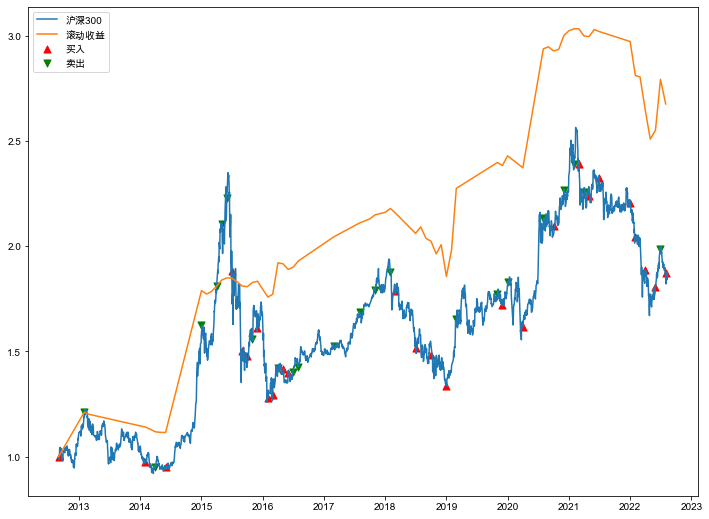

In [14]:
plt.rcParams["font.family"] = 'Arial Unicode MS'  # 设置字体，正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 设置字体，正常显示中文
plt.figure(figsize=(12, 9))

plt.plot(
    fund_for_plt['净值日期'],
    fund_for_plt['单位净值'] / for_plt.loc[0, '单位净值'],
    label='沪深300',
)
plt.plot(
    for_plt['净值日期'],
    for_plt['总资产'] / init_shares,
    label='滚动收益',
)


plt.scatter(
    buy_op_df['净值日期'],
    buy_op_df['单位净值'] / for_plt.loc[0, '单位净值'],
    c='r',
    s=50,
    marker='^',
    label='买入',
)
plt.scatter(
    sell_op_df['净值日期'],
    sell_op_df['单位净值'] / for_plt.loc[0, '单位净值'],
    c='g',
    s=50,
    marker='v',
    label='卖出',
)

plt.axis('tight')
legend(loc='upper left')
